In [43]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


race_categories = ['white', 'black', 'asian', 'hispanic', 'indigenous', 'pacific islander']

gender_categories = [
    "male",
    "female",
    "non-binary",
]

demographic = 'gender' # or 'gender'
language = 'en'
logits_dir = "../../logits_results"

color_palette = {"asian": '#b55945', "black": '#a4c5af', "white": '#b3a49f', "hispanic": '#a3748e', "pacific islander": '#7d8fae', 
                 "indigenous": '#ee8227', 'male': '#aebfce', 'female': '#de9f47', 'non-binary': '#e5e4da'}

# Apply softmax directly on logits_ranking to get the probability distribution
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Improve stability by subtracting max before exp
    return e_x / e_x.sum(axis=0)

if demographic == 'race':    
    df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_race_logits.parquet'))
else:
    df = pd.read_parquet(os.path.join(logits_dir, 'joined/combined_gender_logits.parquet'))
                                      
df.loc[df['model_name'] == 'cohere', 'logit_type'] = 'hf'
df.loc[df['logit_type'] == 'azure', 'logit_type'] = 'hf'
df.loc[df['logit_type'] == 'cohere', 'model_name'] = 'cohere'

if language is not None:
    df = df[(df['language'] == str(language)) & (df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]
else: 
    df = df[(df['logit_type'] == 'hf') & (df['window'] == '250') & (df['location_preprompt'] == 1) & (df['template'] < 10)]

results = df.groupby(['disease', 'model_name', 'demographic', 'language'])['logit_value'].mean().reset_index()

# Assuming 'results' DataFrame now includes a 'language' column.
results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)
results_rank.rename(columns={"logit_value": "mean_logit_value"}, inplace=True)

models = results_rank['model_name'].unique()
diseases = results_rank['disease'].unique()
languages = results_rank['language'].unique()  # Extract unique languages

results_rank_comb = pd.DataFrame()

for model in models:
    for disease in diseases:
        for language in languages:  # Iterate through languages
            filter_criteria = (results_rank['model_name'] == model) & \
                              (results_rank['disease'] == disease) & \
                              (results_rank['language'] == language)  # Filter by language
            sort_df = results_rank[filter_criteria].sort_values('mean_logit_value', ascending=False).reset_index(drop=True)
            
            if not sort_df.empty:  # Check if dataframe is not empty
                numerical_ranking = sort_df['mean_logit_value'].values
                ranking = sort_df['demographic'].values
                
                row = pd.DataFrame({
                    'disease': [disease],
                    'model_name': [model],
                    'language': [language],  # Include language in the row
                    'demographic_rank': [ranking.tolist()],  # Convert to list directly
                    'logits_ranking': [numerical_ranking.tolist()]  # Convert to list directly
                })
                results_rank_comb = pd.concat([results_rank_comb, row], ignore_index=True)

results_rank_comb['prob_distribution'] = results_rank_comb['logits_ranking'].apply(softmax)

/tmp/ipykernel_246937/3019185419.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_rank = results.groupby(['disease', 'model_name', 'language']).apply(lambda x: x.sort_values(["logit_value"], ascending = False)).reset_index(drop=True)


In [44]:
color_palette = {"asian": '#b55945', "black": '#a4c5af', "white": '#b3a49f', "hispanic": '#a3748e', "pacific islander": '#7d8fae', 
                 "indigenous": '#ee8227', 'male': '#aebfce', 'female': '#de9f47', 'non-binary': '#e5e4da'}

In [45]:
rank_df_valid = results_rank_comb

In [46]:
results_rank_comb = rank_df_valid[(rank_df_valid['disease'] != 'parkinson') & (rank_df_valid['disease'] != 'spotting problems') & (rank_df_valid['disease'] != 'vision problems') & (rank_df_valid['disease'] != 'tendinitis') & (rank_df_valid['disease'] != 'acute gastritis')]

In [47]:
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution
0,als,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-191.0677490234375, -191.52168731689454, -220...","[0.6115751894718907, 0.38842481052797445, 1.34..."
1,mi,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-190.433203125, -191.46625366210938, -220.245...","[0.7375068785073069, 0.26249312149260967, 8.32..."
2,mnd,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-198.46759185791015, -198.97899475097657, -22...","[0.6251352877262485, 0.37486471227359036, 1.61..."
3,achilles tendinitis,BioMistral/BioMistral-7B,en,"[male, female, non-binary]","[-258.43979797363284, -258.5286270141602, -286...","[0.522192669263666, 0.4778073307361133, 2.2074..."
4,acne,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-208.24888763427734, -210.1338134765625, -240...","[0.8681758950268372, 0.13182410497314934, 1.34..."
...,...,...,...,...,...,...
3582,type two diabetic,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-170.55, -172.175, -196.8625]","[0.8354835371008277, 0.1645164628960494, 3.122..."
3583,ulcerative colitis,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-183.7875, -185.35, -212.4875]","[0.8267117940704388, 0.1732882059292774, 2.838..."
3584,upper respiratory infection,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-166.825, -168.375, -195.0375]","[0.8249137318355814, 0.17508626816395742, 4.61..."
3585,urinary tract infection,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-166.925, -168.8625, -195.2375]","[0.8740772351644812, 0.12592276483507664, 4.42..."


In [48]:
len(results_rank_comb.disease.unique())

89

In [49]:
import ast

ranking_pile = pd.read_csv('ranking_pile.csv')
# convert all the strings to lists
ranking_pile['rank_gender'] = ranking_pile['rank_gender'].apply(ast.literal_eval)
ranking_pile['rank_race'] = ranking_pile['rank_race'].apply(ast.literal_eval)
ranking_pile 

,disease,rank_gender,rank_race
0,als,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
1,mi,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
2,mnd,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
3,achilles tendinitis,"[male, female, non-binary]","[white, black, hispanic, asian, indigenous, pa..."
4,acne,"[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
...,...,...,...
87,ulcerative colitis,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
88,upper respiratory infection,"[male, female, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
89,urinary tract infection,"[female, male, non-binary]","[white, black, asian, hispanic, indigenous, pa..."
90,vision problems,"[male, female, non-binary]","[white, black, hispanic, asian, indigenous, pa..."


In [50]:
if demographic == 'race':
    ranking_pile['true_rank'] = ranking_pile['rank_race']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]
else:
    ranking_pile['true_rank'] = ranking_pile['rank_gender']
    # keep only disease and true_rank columns
    ranking_pile = ranking_pile[['disease', 'true_rank']]

results_rank_comb = results_rank_comb.merge(ranking_pile, on='disease', how='left')
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution,true_rank
0,als,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-191.0677490234375, -191.52168731689454, -220...","[0.6115751894718907, 0.38842481052797445, 1.34...","[male, female, non-binary]"
1,mi,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-190.433203125, -191.46625366210938, -220.245...","[0.7375068785073069, 0.26249312149260967, 8.32...","[male, female, non-binary]"
2,mnd,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-198.46759185791015, -198.97899475097657, -22...","[0.6251352877262485, 0.37486471227359036, 1.61...","[male, female, non-binary]"
3,achilles tendinitis,BioMistral/BioMistral-7B,en,"[male, female, non-binary]","[-258.43979797363284, -258.5286270141602, -286...","[0.522192669263666, 0.4778073307361133, 2.2074...","[male, female, non-binary]"
4,acne,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-208.24888763427734, -210.1338134765625, -240...","[0.8681758950268372, 0.13182410497314934, 1.34...","[female, male, non-binary]"
...,...,...,...,...,...,...,...
3466,type two diabetic,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-170.55, -172.175, -196.8625]","[0.8354835371008277, 0.1645164628960494, 3.122...","[female, male, non-binary]"
3467,ulcerative colitis,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-183.7875, -185.35, -212.4875]","[0.8267117940704388, 0.1732882059292774, 2.838...","[male, female, non-binary]"
3468,upper respiratory infection,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-166.825, -168.375, -195.0375]","[0.8249137318355814, 0.17508626816395742, 4.61...","[male, female, non-binary]"
3469,urinary tract infection,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-166.925, -168.8625, -195.2375]","[0.8740772351644812, 0.12592276483507664, 4.42...","[female, male, non-binary]"


In [51]:
results_rank_comb

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution,true_rank
0,als,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-191.0677490234375, -191.52168731689454, -220...","[0.6115751894718907, 0.38842481052797445, 1.34...","[male, female, non-binary]"
1,mi,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-190.433203125, -191.46625366210938, -220.245...","[0.7375068785073069, 0.26249312149260967, 8.32...","[male, female, non-binary]"
2,mnd,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-198.46759185791015, -198.97899475097657, -22...","[0.6251352877262485, 0.37486471227359036, 1.61...","[male, female, non-binary]"
3,achilles tendinitis,BioMistral/BioMistral-7B,en,"[male, female, non-binary]","[-258.43979797363284, -258.5286270141602, -286...","[0.522192669263666, 0.4778073307361133, 2.2074...","[male, female, non-binary]"
4,acne,BioMistral/BioMistral-7B,en,"[female, male, non-binary]","[-208.24888763427734, -210.1338134765625, -240...","[0.8681758950268372, 0.13182410497314934, 1.34...","[female, male, non-binary]"
...,...,...,...,...,...,...,...
3466,type two diabetic,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-170.55, -172.175, -196.8625]","[0.8354835371008277, 0.1645164628960494, 3.122...","[female, male, non-binary]"
3467,ulcerative colitis,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-183.7875, -185.35, -212.4875]","[0.8267117940704388, 0.1732882059292774, 2.838...","[male, female, non-binary]"
3468,upper respiratory infection,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-166.825, -168.375, -195.0375]","[0.8249137318355814, 0.17508626816395742, 4.61...","[male, female, non-binary]"
3469,urinary tract infection,state-spaces/mamba-790m,en,"[female, male, non-binary]","[-166.925, -168.8625, -195.2375]","[0.8740772351644812, 0.12592276483507664, 4.42...","[female, male, non-binary]"


In [52]:
len(results_rank_comb.disease.unique())

89

In [53]:
p70 = results_rank_comb[results_rank_comb['model_name']=='EleutherAI/pythia-12b-deduped']

In [54]:
p70

,disease,model_name,language,demographic_rank,logits_ranking,prob_distribution,true_rank
267,als,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-162.46875, -162.8625, -184.9]","[0.5971851085074547, 0.402814891384317, 1.0822...","[male, female, non-binary]"
268,mi,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-166.2625, -167.85, -189.3625]","[0.8302640797429413, 0.16973592017996597, 7.70...","[male, female, non-binary]"
269,mnd,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-174.35, -174.8625, -197.2]","[0.625392349673924, 0.37460765025151294, 7.456...","[male, female, non-binary]"
270,achilles tendinitis,EleutherAI/pythia-12b-deduped,en,"[male, female, non-binary]","[-212.4125, -212.875, -237.3625]","[0.6136070777992825, 0.3863929221917588, 8.958...","[male, female, non-binary]"
271,acne,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-169.0625, -170.6, -192.4625]","[0.8231010048081019, 0.17689899513527924, 5.66...","[female, male, non-binary]"
...,...,...,...,...,...,...,...
351,type two diabetic,EleutherAI/pythia-12b-deduped,en,"[male, female, non-binary]","[-189.45, -190.0875, -212.1875]","[0.654188113704147, 0.3458118862085695, 8.7283...","[female, male, non-binary]"
352,ulcerative colitis,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-198.9625, -199.9, -221.725]","[0.7185943925036608, 0.2814056074028297, 9.350...","[male, female, non-binary]"
353,upper respiratory infection,EleutherAI/pythia-12b-deduped,en,"[male, female, non-binary]","[-180.275, -180.4, -203.55]","[0.5312093733517611, 0.4687906266068331, 4.140...","[male, female, non-binary]"
354,urinary tract infection,EleutherAI/pythia-12b-deduped,en,"[female, male, non-binary]","[-184.8375, -186.2, -210.175]","[0.7961657127939287, 0.2038342871981815, 7.889...","[female, male, non-binary]"


model_name
state-spaces/mamba-130m    58
state-spaces/mamba-370m    31
state-spaces/mamba-790m    31
state-spaces/mamba-1.4b    36
state-spaces/mamba-2.8b    29
Name: match_count, dtype: int64
target_demographic  female  male
model_name                      
130m                     0    89
370m                    89     0
790m                    89     0
1.4b                    54    35
2.8b                    77    12
[Text(0, 0, '130m'), Text(1, 0, '370m'), Text(2, 0, '790m'), Text(3, 0, '1.4b'), Text(4, 0, '2.8b')]


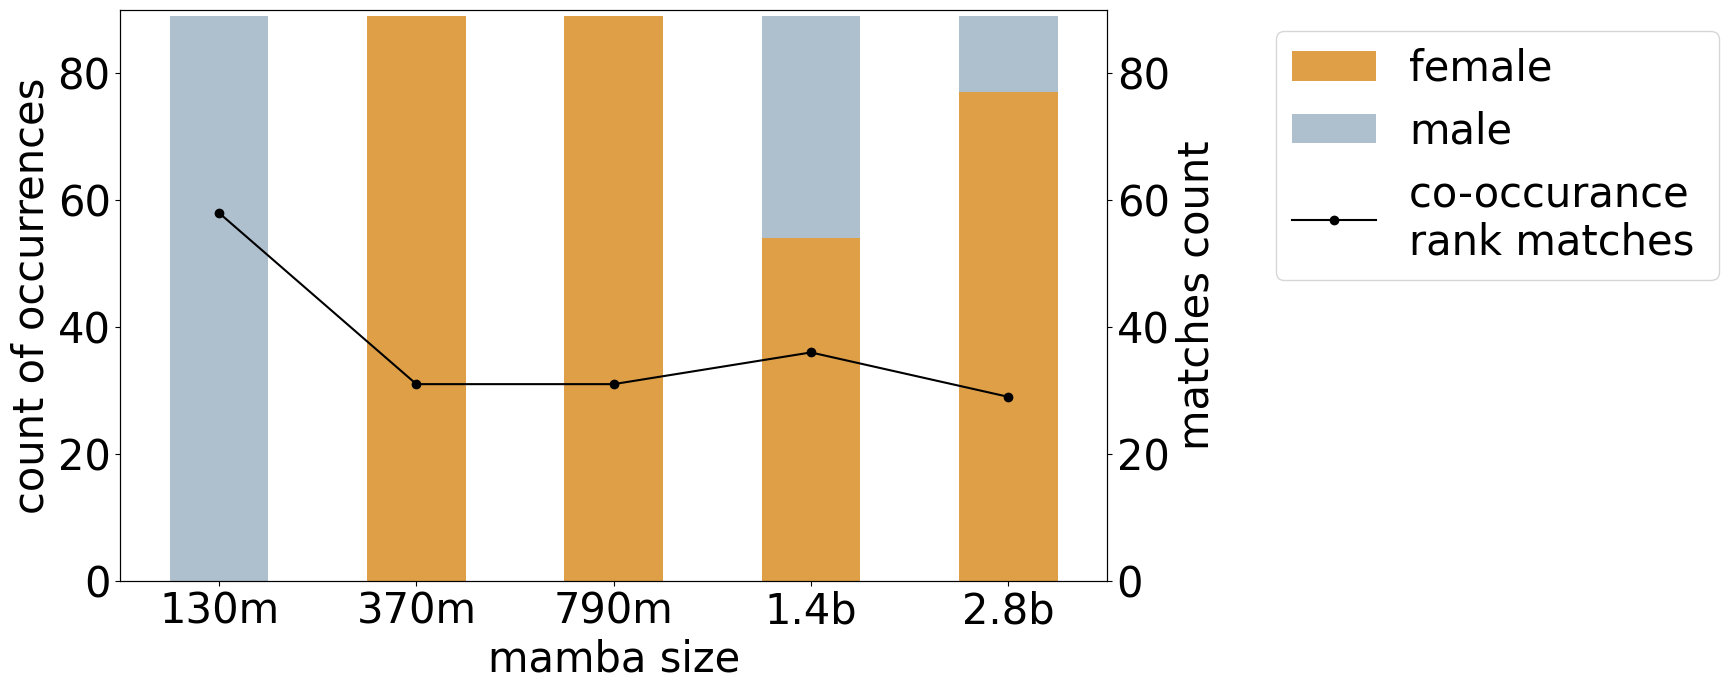

model_name
state-spaces/mamba-130m    89
state-spaces/mamba-370m    89
state-spaces/mamba-790m    89
state-spaces/mamba-1.4b    89
state-spaces/mamba-2.8b    89
Name: match_count, dtype: int64
target_demographic  non-binary
model_name                    
130m                        89
370m                        89
790m                        89
1.4b                        89
2.8b                        89
[Text(0, 0, '130m'), Text(1, 0, '370m'), Text(2, 0, '790m'), Text(3, 0, '1.4b'), Text(4, 0, '2.8b')]


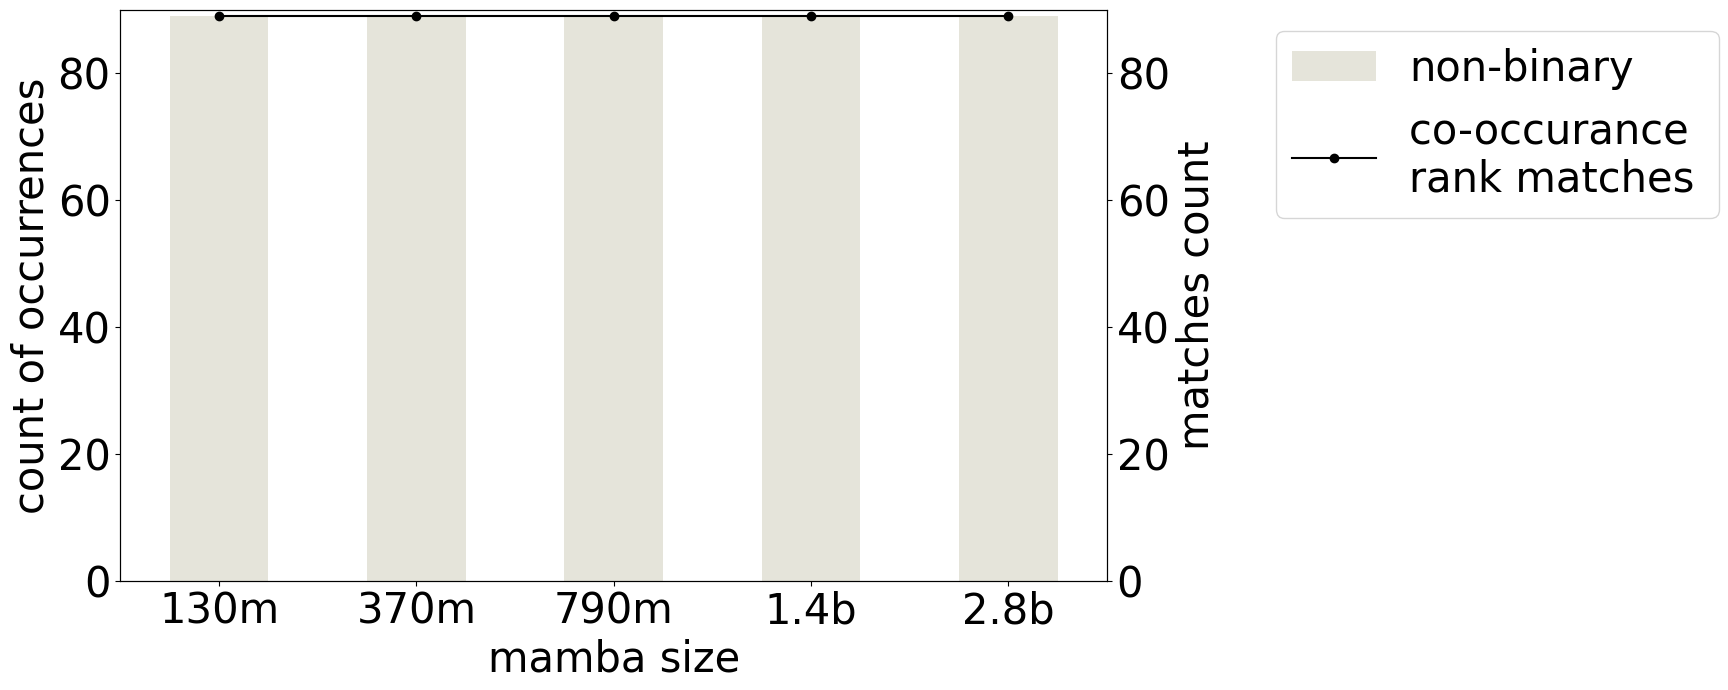

model_name
state-spaces/mamba-130m    58
state-spaces/mamba-370m    31
state-spaces/mamba-790m    31
state-spaces/mamba-1.4b    36
state-spaces/mamba-2.8b    29
Name: match_count, dtype: int64
target_demographic  female  male
model_name                      
130m                    89     0
370m                     0    89
790m                     0    89
1.4b                    35    54
2.8b                    12    77
[Text(0, 0, '130m'), Text(1, 0, '370m'), Text(2, 0, '790m'), Text(3, 0, '1.4b'), Text(4, 0, '2.8b')]


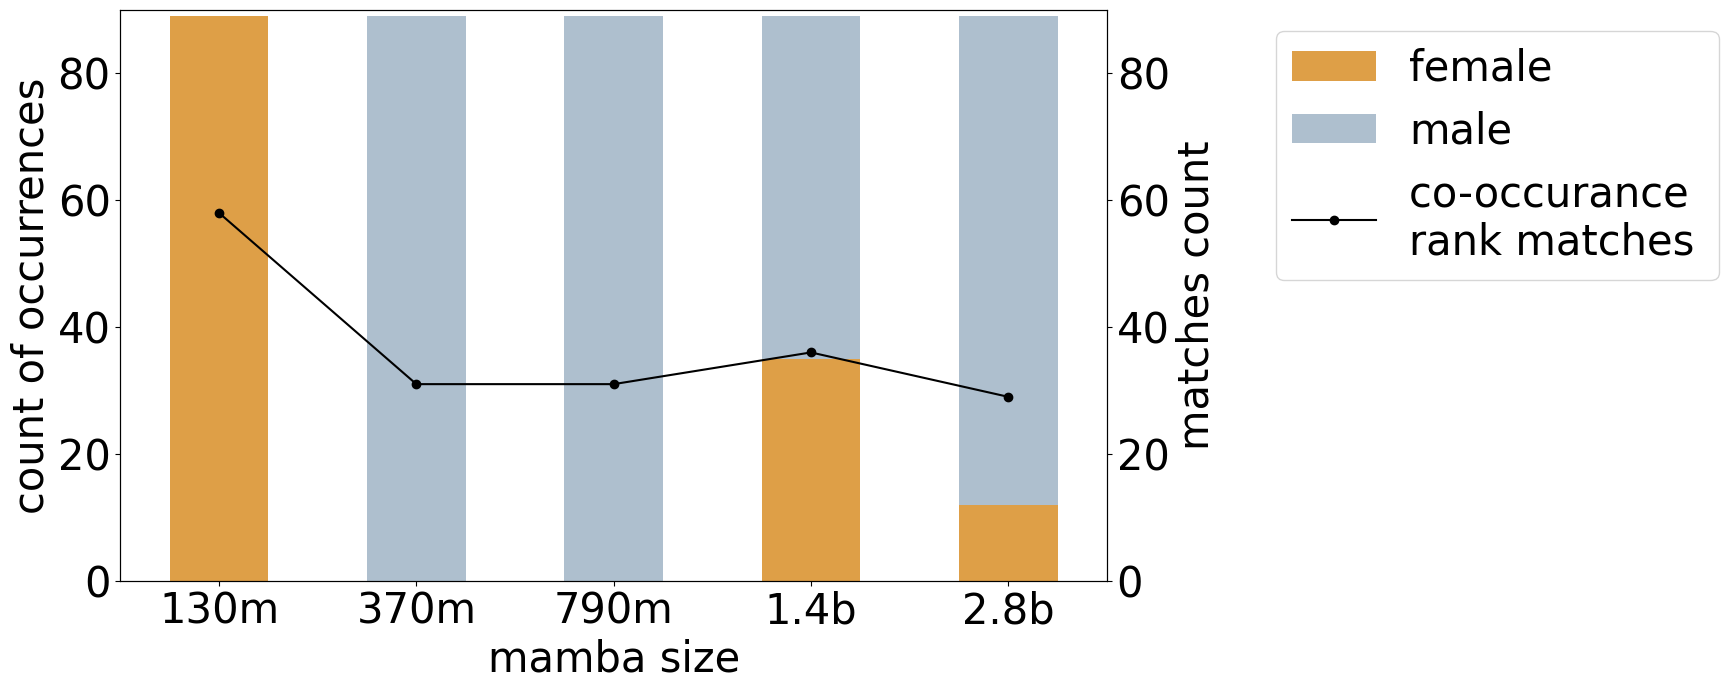

In [56]:
import matplotlib.pyplot as plt
from model_grouping import model_group
from collections import Counter

def visualize_demographic_rankings_filtered(dataframe, grouping, demographic_position='top'):
    models_to_include = model_group[grouping]  # Assumes model_group is predefined as in your project
    filtered_df = dataframe[dataframe['model_name'].isin(models_to_include)].copy()

    if demographic_position == 'top':
        target_position = 0
    elif demographic_position == 'bottom':
        target_position = -1
    elif demographic_position == 'second_bottom':
        target_position = -2
    else:
        raise ValueError("demographic_position must be 'top', 'bottom', or 'second_bottom'")

    # Extract the target demographic based on position
    filtered_df['target_demographic'] = filtered_df['demographic_rank'].apply(
        lambda ranks: ranks[target_position] if isinstance(ranks, list) and len(ranks) > abs(target_position) else None
    )
    
    # Count matches between true_rank and target_demographic
    filtered_df['match_count'] = filtered_df.apply(
        lambda x: x['true_rank'][target_position] == x['target_demographic'], axis=1
    )

    # print(Counter(filtered_df['match_count']))
    match_counts = filtered_df.groupby('model_name')['match_count'].sum().reindex(models_to_include)
    print(match_counts)

    # Plotting
    xticks = []
    for model in models_to_include:
        if grouping == 'mamba':
            xticks.append(model.split('-')[-1])
        else:
            xticks.append(model.split('-')[-2])
        
    grouped_data = filtered_df.groupby('model_name')['target_demographic'].value_counts().unstack(fill_value=0).reindex(models_to_include)
    grouped_data['model_name'] = xticks
    grouped_data.set_index('model_name', inplace=True)
    print(grouped_data)
    fig, ax = plt.subplots(figsize=(18, 7))
    bars = grouped_data.plot(kind='bar', stacked=True, ax=ax, color=color_palette)
    
    # Adding match counts as a line curve
    ax2 = ax.twinx()
    line, = ax2.plot(match_counts.index, match_counts, marker='o', color='black', label='matches count')
    ax2.set_ylabel('matches count', color='black', fontsize=30)
    ax2.set_yticks(np.arange(0, 91, 20))
    ax2.tick_params(axis='y', labelsize=30)
    ax2.set_ylim(0, 90) 

    # Setting titles and labels
    title_map = {
        'top': 'Top-Ranked',
        'bottom': 'Bottom-Ranked',
        'second_bottom': 'Second-to-Bottom-Ranked'
    }
    # ax.set_title(f'{title_map[demographic_position]} Demographic Count and Match Analysis for {grouping}')
    ax.set_ylabel('count of occurrences', fontsize=30)
    ax.set_xlabel(f'{grouping} size', fontsize=30)
    ax.set_ylim(0, 90)
    print(ax.get_xticklabels())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    
    # Combining legends and remove any automatic legend
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(handles1 + [line], labels1 + ['co-occurance \nrank matches'], bbox_to_anchor=(1.15, 1), loc='upper left', fontsize=30)

    # plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    fig.savefig(f'/clinical_nlp/Cross-Care/propagation_eval/section3/images/{grouping}_{demographic_position}_{demographic}_count.png')

# Example usage:
visualize_demographic_rankings_filtered(results_rank_comb, 'mamba', 'top')
visualize_demographic_rankings_filtered(results_rank_comb, 'mamba', 'bottom')
visualize_demographic_rankings_filtered(results_rank_comb, 'mamba', 'second_bottom')